In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os.path
import biophysnn

import bindingdata

from importlib import reload
reload(biophysnn)

<module 'biophysnn' from '/gpfs/commons/home/daknowles/pooledRBPs/biophysical_cnn/biophysnn.py'>

## Loading data

In [2]:
binding_data = pd.read_csv("/gpfs/commons/home/daknowles/RIPnet/all_hnrnpk_rep1_stranded.narrowPeak.gz", sep='\t', usecols=range(6), names=("chrom","start","end","name","score","strand"))
binding_data = binding_data[ ~binding_data['chrom'].isin(["chrX","chrY"]) ] # only keep autosomes (non sex chromosomes)
binding_data = binding_data.sort_values(['chrom', 'start']).drop_duplicates() # sort so we can interleave negatives
binding_data

,chrom,start,end,name,score,strand
0,chr1,16099,16580,all_hnrnpk_rep1_neg_peak_35,81,-
1,chr1,19237,19896,all_hnrnpk_rep1_neg_peak_36,48,-
2,chr1,136471,137136,all_hnrnpk_rep1_neg_peak_37,73,-
3,chr1,186383,187169,all_hnrnpk_rep1_neg_peak_38,54,-
4,chr1,190825,191102,all_hnrnpk_rep1_neg_peak_39,51,-
...,...,...,...,...,...,...
149418,chr9,138179008,138179394,all_hnrnpk_rep1_pos_peak_74674,72,+
149419,chr9,138232102,138232344,all_hnrnpk_rep1_pos_peak_74675,362,+
149420,chr9,138232980,138233211,all_hnrnpk_rep1_pos_peak_74676,254,+
149421,chr9,138276024,138276247,all_hnrnpk_rep1_pos_peak_74677,340,+


In [3]:
unbound = pd.read_csv("unbound_regions.bed.gz", 
                      sep = "\t", 
                      names = ["chrom", "start", "end", "name", "strand", "counts", "length"],
                      index_col = False)
unbound

/gpfs/commons/home/daknowles/.conda/envs/asb/lib/python3.8/site-packages/pandas/util/_decorators.py:311: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  return func(*args, **kwargs)


,chrom,start,end,name,strand,counts,length
0,chr1,17369,17436,ENSG00000278267.1,-,53,68
1,chr1,135141,135895,ENSG00000268903.1,-,903,755
2,chr1,137682,137965,ENSG00000269981.1,-,1206,284
3,chr1,185217,186383,ENSG00000279457.4,-,295,1397
4,chr1,187169,190825,ENSG00000279457.4,-,295,1397
...,...,...,...,...,...,...,...
126565,chrM,14149,14673,ENSG00000198695.2,-,59390,525
126566,chrM,14674,14742,ENSG00000210194.1,-,598,69
126567,chrM,14747,15887,ENSG00000198727.2,+,247327,1141
126568,chrM,15888,15953,ENSG00000210195.2,+,663,66


In [4]:
unbound["score"] = 0
bind_all = pd.concat([binding_data,
           unbound.loc[:, ~unbound.columns.isin(['counts', 'length'])]], 
          axis=0)
bind_all.iloc[10]

chrom                            chr1
start                          629752
end                            629972
name      all_hnrnpk_rep1_pos_peak_23
score                             246
strand                              +
Name: 74767, dtype: object

In [5]:
test_chromosomes = ["chr1"]
test_data = bind_all[ bind_all['chrom'].isin( test_chromosomes ) ]

validation_chromosomes = ["chr2","chr3"]
validation_data = bind_all[ bind_all['chrom'].isin(validation_chromosomes) ]

train_chromosomes = ["chr%i" % i for i in range(4, 22+1)]
train_data = bind_all[ bind_all['chrom'].isin( train_chromosomes ) ]

test_data.shape[0] / bind_all.shape[0], validation_data.shape[0] / bind_all.shape[0]

(0.09493766126042802, 0.1428707751144192)

In [6]:
genome = pickle.load(open("/gpfs/commons/home/daknowles/knowles_lab/index/hg38/hg38.pkl","rb")) # this is here in case there's hg38 data you want to analyse

In [7]:
pwm_dat = np.load("/gpfs/commons/home/daknowles/apex_seq/pwms.npz")
pwm_names = pwm_dat['names']
pwms = pwm_dat['pwms']

pwms[pwms > 0].min()
log_pwms = np.log(pwms + 1e-4)

# Convert to actual PWM
w = torch.tensor(log_pwms, dtype=torch.float).transpose(0,2)
w_norm = w - w.mean(1,keepdims=True)

w_norm.shape

torch.Size([453, 4, 7])

In [8]:
specific_pwms = w_norm[ np.array([ "HNRNPK" in g for g in pwm_names ]) ]
specific_pwms.shape

torch.Size([5, 4, 7])

In [91]:
0 * [1]

[]

In [40]:
perf = {}
for num_chunks in range(1,12):
    print(num_chunks)
    cnn = biophysnn.CNN_1d(use_flipping=False, 
                           nchannels = [4, 16, 16, 16], 
                           n_hidden = 16, 
                           num_chunks = num_chunks, 
                           pool_factor = 4, 
                           filter_widths = [11, 7, 7])
    print("Input length", cnn.seq_len)
    train_accs, val_accs, train_aucs, val_aucs = biophysnn.train_model(cnn, 
                                                                       train_data, 
                                                                       validation_data, 
                                                                       genome, 
                                                                       num_workers=8,
                                                                       check_point_filename="checkpoints/cnn/%i.pt" % num_chunks, 
                                                                       verbose = False)
    perf[num_chunks] = np.max(val_aucs)

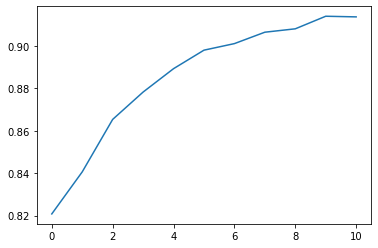

In [37]:
plt.plot(perf.values())

In [39]:
perf.values()

dict_values([0.8207643760358998, 0.8405880586145534, 0.8653253527963398, 0.8782221537639632, 0.8892499523871085, 0.8979777105035043, 0.9010687659137242, 0.9064452856092446, 0.9080424362054823, 0.913971496917465, 0.9136715029197534])

In [ ]:
reload(biophysnn)
reload(bindingdata)
#perf2 = {}
for pool_width in [23,25,27,29,31]: # [3,5,7,9,11,13, 15, 17, 19, 21]:
    print(pool_width)
    cnn = biophysnn.LogConvExpNet(
                           nchannels = [4, 16, 16, 16], 
                           n_hidden = 16, 
                           num_chunks = 9, 
                           pool_stride = 4, 
                           pool_width = pool_width,
                           filter_widths = [11, 7, 7] ,
                           pooling= True)
    train_accs, val_accs, train_aucs, val_aucs = biophysnn.train_model(cnn, 
                                                                       train_data, 
                                                                       validation_data, 
                                                                       genome, 
                                                                       num_workers=0,
                                                                       check_point_filename="checkpoints/cnn/log_conv_exp%i.pt" % pool_width, 
                                                                       verbose = False)
    perf2[pool_width] = np.max(val_aucs)

23
Receptive field: 529 Chunk size: 64 Number chunks: 9


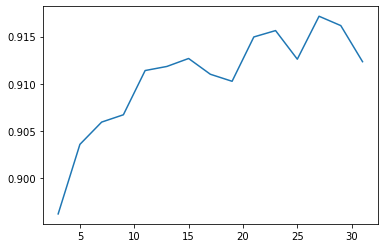

In [15]:
plt.plot(perf2.keys(),perf2.values())

In [23]:
best_pool_width = list(perf2.keys())[np.argmax(list(perf2.values()))] # 27
cnn = biophysnn.LogConvExpNet(
                           nchannels = [4, 16, 16, 16], 
                           n_hidden = 16, 
                           num_chunks = 9, 
                           pool_stride = 4, 
                           pool_width = best_pool_width,
                           filter_widths = [11, 7, 7] ,
                           pooling = True)
cnn.seq_len

Receptive field: 613 Chunk size: 64 Number chunks: 9


1189

In [45]:
perf3

{1: 0.7676979961053899,
 2: 0.8526794878900019,
 4: 0.9157489155272509,
 6: 0.9279618262488177,
 8: 0.9274455464933697}

## ExpConvLogConv

In [44]:
reload(biophysnn)
reload(bindingdata)
perf3 = {}
for pool_stride in [1,2,4,6,8,12,16]:
    cnn = biophysnn.LogConvExpNet(
                               nchannels = [4, 16, 16, 16], 
                               n_hidden = 16, 
                               num_chunks = 9, 
                               pool_stride = pool_stride, 
                               pool_width = 27,
                               filter_widths = [11, 7, 7] ,
                               pooling= False)
    train_accs, val_accs, train_aucs, val_aucs = biophysnn.train_model(cnn, 
                                                                       train_data, 
                                                                       validation_data, 
                                                                       genome, 
                                                                       num_workers=8,
                                                                       check_point_filename="checkpoints/cnn/exp_conv_log_conv%i.pt" % pool_stride, 
                                                                       verbose = False)
    perf3[pool_stride] = np.max(val_aucs)

0.541324854612918

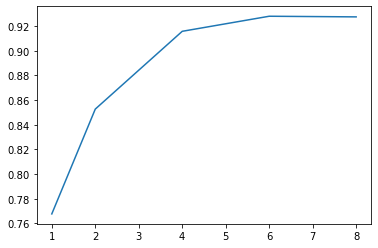

In [46]:
plt.plot(perf3.keys(),perf3.values())

In [53]:
pool_stride = 4
check_point_filename="checkpoints/cnn/exp_conv_log_conv%i.pt" % pool_stride
cnn = biophysnn.LogConvExpNet(
                   nchannels = [4, 16, 16, 16], 
                   n_hidden = 16, 
                   num_chunks = 9, 
                   pool_stride = pool_stride, 
                   pool_width = 27,
                   filter_widths = [11, 7, 7] ,
                   pooling= False)
cnn.load_state_dict(torch.load(check_point_filename))

Receptive field: 613 Chunk size: 64 Number chunks: 9


<All keys matched successfully>

In [62]:
param_dict = dict(cnn.named_parameters())
param_dict.keys()

dict_keys(['conv_net.0.weight', 'conv_net.0.bias', 'conv_net.2.weight', 'conv_net.4.weight', 'conv_net.4.bias', 'conv_net.6.weight', 'conv_net.8.weight', 'conv_net.8.bias', 'conv_net.10.weight', 'dense_net.0.weight', 'dense_net.0.bias', 'dense_net.3.weight', 'dense_net.3.bias'])

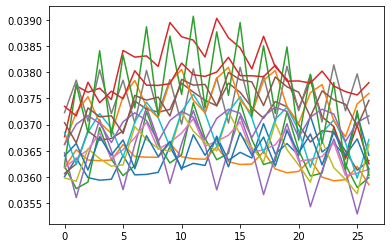

In [76]:
avg_pooler = F.softplus(param_dict['conv_net.2.weight'].data)
for i in range(16): plt.plot(avg_pooler[i,i,:])

In [81]:
aclone = avg_pooler.clone()
for i in range(16): aclone[i,i,:] = 0. 
aclone.max().item()

4.8183457693085074e-05

So doesn't change much from init. 

In [1]:
pool_stride = 4
reload(biophysnn)

cnn = biophysnn.LogConvExpNet(
                   nchannels = [4, 16, 16, 16], 
                   n_hidden = 16, 
                   num_chunks = 9, 
                   pool_stride = pool_stride, 
                   pool_width = 27,
                   filter_widths = [11, 7, 7] ,
                   avgpool = [True, False, False], 
                   exp_log = [True, False, False])
train_accs, val_accs, train_aucs, val_aucs = biophysnn.train_model(cnn, 
               train_data, 
               validation_data, 
               genome, 
               num_workers=8,
               check_point_filename="checkpoint.pt", 
               verbose = True)

NameError: name 'reload' is not defined

## Test flipped CNN

1 Receptive field: 10 Chunk size: 4 Number chunks: 5
Receptive field: 10 Chunk size: 4 Number chunks: 5
2 Receptive field: 10 Chunk size: 4 Number chunks: 5
Receptive field: 10 Chunk size: 4 Number chunks: 5
3 Receptive field: 10 Chunk size: 4 Number chunks: 5
Receptive field: 10 Chunk size: 4 Number chunks: 5
4 Receptive field: 10 Chunk size: 4 Number chunks: 5
Receptive field: 10 Chunk size: 4 Number chunks: 5
5 Receptive field: 10 Chunk size: 4 Number chunks: 5
Receptive field: 10 Chunk size: 4 Number chunks: 5
6 Receptive field: 10 Chunk size: 4 Number chunks: 5
Receptive field: 10 Chunk size: 4 Number chunks: 5
7 Receptive field: 10 Chunk size: 4 Number chunks: 5
Receptive field: 10 Chunk size: 4 Number chunks: 5
8 Receptive field: 10 Chunk size: 4 Number chunks: 5
Receptive field: 10 Chunk size: 4 Number chunks: 5
9 Receptive field: 10 Chunk size: 4 Number chunks: 5
Receptive field: 10 Chunk size: 4 Number chunks: 5
10 Receptive field: 10 Chunk size: 4 Number chunks: 5
Receptive 

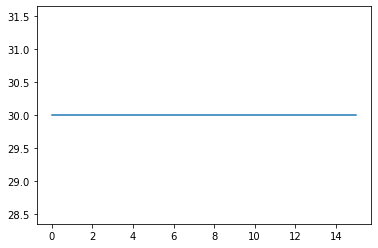

In [16]:
reload(biophysnn)

test_acc_flipped = {}
test_auc_flipped = {}
seq_lens = {}
test_acc_regular = {}
test_auc_regular = {}
for num_filters in range(1,17): 
    print(num_filters, end = " ")
    flipped_cnn = biophysnn.CNN_1d(use_flipping=True, nchannels = [4, num_filters], n_hidden = 16, filter_widths = [10])
    seq_lens[num_filters] = flipped_cnn.seq_len
    train_accs, val_accs, train_aucs, val_aucs = biophysnn.train_model(flipped_cnn, train_data, validation_data, genome, verbose = False)
    test_dataset = bindingdata.BedPeaksDataset(test_data, genome, flipped_cnn.seq_len)
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1000)
    test_loss, test_acc_flipped[num_filters], test_auc_flipped[num_filters], _, _, _ = biophysnn.run_one_epoch(test_dataloader, flipped_cnn, None)

    regular_cnn = biophysnn.CNN_1d(use_flipping=False,  nchannels = [4, num_filters], n_hidden = 16, filter_widths = [11])
    train_accs, val_accs, train_aucs, val_aucs = biophysnn.train_model(regular_cnn, train_data, validation_data, genome, verbose = False)
    test_dataset = bindingdata.BedPeaksDataset(test_data, genome, regular_cnn.seq_len)
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1000)
    test_loss, test_acc_regular[num_filters], test_auc_regular[num_filters], _, _, _ = biophysnn.run_one_epoch(test_dataloader, regular_cnn, None)
plt.plot(list(seq_lens.values()))

In [20]:
test_auc_flipped_values = np.array(list(test_acc_flipped.values()))
print("%.3f +/- %.3f" % (test_acc_flipped_values.mean(), test_acc_flipped_values.std()))

0.609 +/- 0.006


In [19]:
test_auc_regular_values = np.array(list(test_acc_regular.values()))
print("%.3f +/- %.3f" % (test_acc_regular_values.mean(), test_acc_regular_values.std()))

0.614 +/- 0.010


In [ ]:
test_acc_regular_values

Wow really bad AUCs! Not looking at enough sequence. 

In [25]:
regular_cnn.seq_len

30

In [ ]:
reload(biophysnn)

config = {
    'batch_size': 100,
 'dropout': 0.1, 
 'depth': 3,
 'first_filter_width': 11,
 'filter_width' : 5, 
 'first_pool_stride' : 7, 
 'pool_stride' : 4, 
 'pool_overlap' : 4,
 'lr': 1e-3,
 'n_channel': 16,
 'n_hidden' : 16,
 'weight_decay': 0.,
 'avgpool' : [True,False], 
 'exp_log' : [True,False], 
 'num_chunks' : 7
}

trainer = biophysnn.Trainable(config)

train_metrics_list, val_metrics_list = trainer.my_train(verbose = True,
 checkpoint_dir = "checkpoint")

In [2]:
reload(biophysnn)
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler
from ray.tune import Analysis
config = {
    'batch_size': tune.choice([100,200]),
 'dropout': tune.choice([0.,0.1,0.25]), 
 'depth': tune.randint(2,5),
 'first_filter_width': tune.choice([5,7,9,11]),
 'filter_width' : tune.choice([3,5,7]), 
 'first_pool_stride' : tune.randint(2,9), 
 'pool_stride' : tune.randint(2,5), 
 'pool_overlap' : tune.randint(0,6),
 'lr': tune.loguniform(1e-4, 1e-2),
 'n_channel': tune.choice([16,32]),
 'n_hidden' : tune.choice([16,32,64]),
 'weight_decay': tune.loguniform(1e-3, 1e-8),
 'avgpool' : tune.choice([[True,False], [False,False], [True,True]]) ,
 'exp_log' : tune.choice([[True,False], [False,False], [True,True]]) , 
 'num_chunks' : tune.choice([3,5,7,9,11]),
 'max_seq_len' : 1028, 
}

if False: 
    result = tune.run(
        biophysnn.Trainable,
        config = config,
        reuse_actors = True, 
        name = "logConvExpHNRNP", 
        num_samples=100,
        checkpoint_freq=1,
        scheduler = ASHAScheduler(
            max_t=20, 
            grace_period=2),
        resources_per_trial={'gpu': 1} if torch.cuda.is_available() else {"cpu": 28, "gpu": 0},
        metric="val_auroc", # metric to optimize
        mode="max"
    )

In [115]:
import ray
ray.shutdown()

In [4]:

analysis = Analysis("/gpfs/commons/home/daknowles/ray_results/logConvExpHNRNP/")

analysis.get_best_config("val_auroc","max")

#df = analysis.dataframe()


{'avgpool': [False, False],
 'batch_size': 200,
 'depth': 3,
 'dropout': 0.25,
 'exp_log': [False, False],
 'filter_width': 7,
 'first_filter_width': 11,
 'first_pool_stride': 8,
 'lr': 0.0007007412124604625,
 'max_seq_len': 1028,
 'n_channel': 32,
 'n_hidden': 64,
 'num_chunks': 9,
 'pool_overlap': 4,
 'pool_stride': 3,
 'weight_decay': 0.0002876588506983289}

In [7]:
df = analysis.dataframe()
df.val_auroc.max()

0.9197334943826956

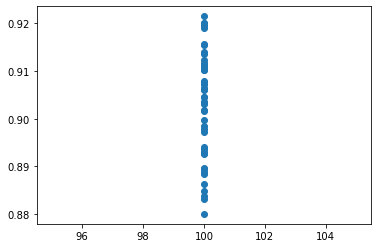

In [91]:
plt.scatter(df["config/batch_size"], df.val_auroc) # no obvious difference

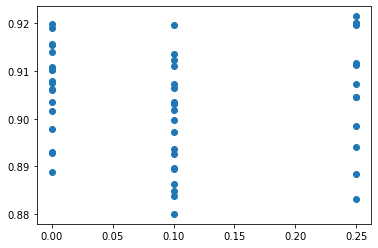

In [92]:
plt.scatter(df["config/dropout"], df.val_auroc)# no obvious difference

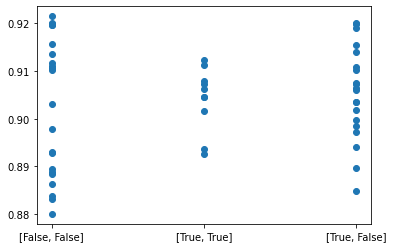

In [93]:
plt.scatter(df["config/exp_log"].astype(str), df.val_auroc) # no obvious difference

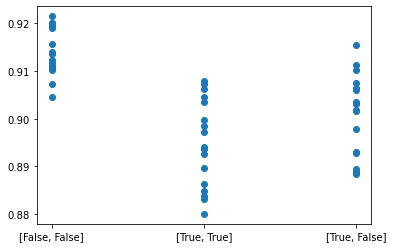

In [94]:
plt.scatter(df["config/avgpool"].astype(str), df.val_auroc) # no obvious difference

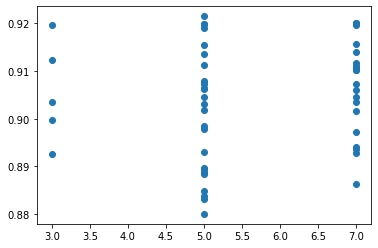

In [95]:
plt.scatter(df["config/filter_width"], df.val_auroc) 

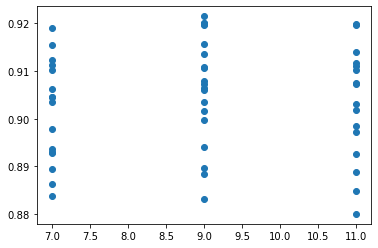

In [96]:
plt.scatter(df["config/first_filter_width"], df.val_auroc)  # 5 is too short, 9 seems good

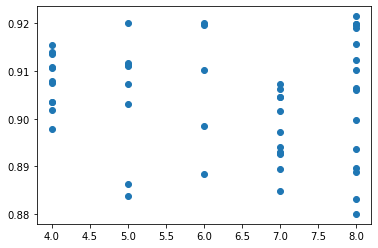

In [97]:
plt.scatter(df["config/first_pool_stride"], df.val_auroc) # at least 4

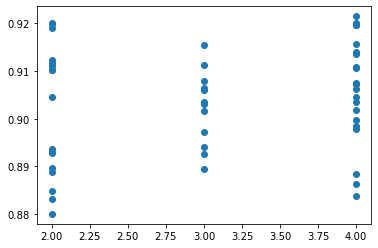

In [98]:
plt.scatter(df["config/pool_stride"], df.val_auroc)

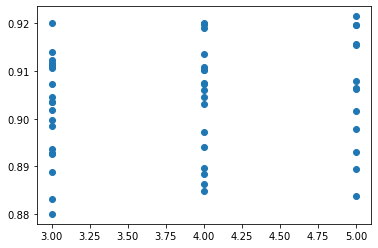

In [99]:
plt.scatter(df["config/pool_overlap"], df.val_auroc) # 4 is good, <3 is bad

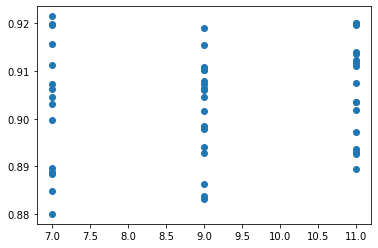

In [100]:
plt.scatter(df["config/num_chunks"], df.val_auroc) # 9 is best

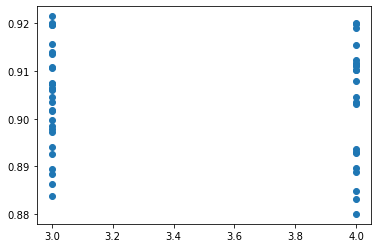

In [101]:
plt.scatter(df["config/depth"], df.val_auroc)  # 3 is good

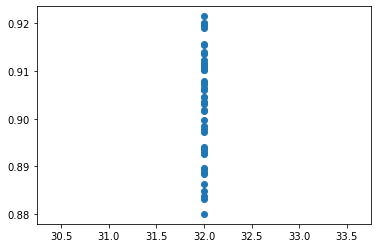

In [102]:
plt.scatter(df["config/n_channel"], df.val_auroc)

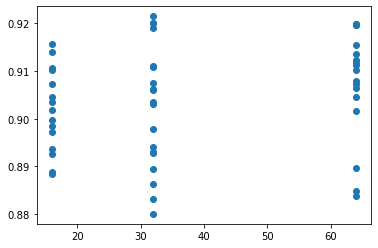

In [103]:
plt.scatter(df["config/n_hidden"], df.val_auroc)

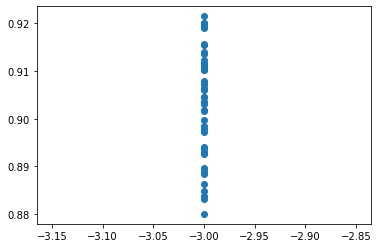

In [104]:
plt.scatter(np.log10(df["config/lr"]), df.val_auroc)

/gpfs/commons/home/daknowles/.conda/envs/asb/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


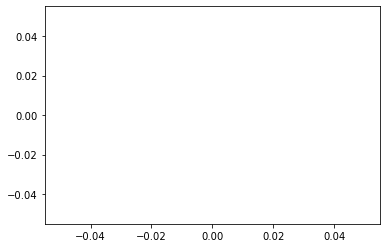

In [105]:
plt.scatter(np.log10(df["config/weight_decay"]), df.val_auroc)

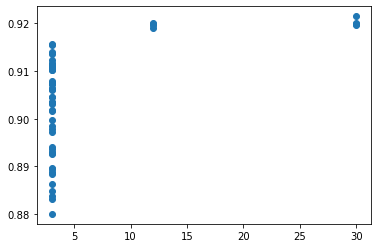

In [106]:
plt.scatter(df["training_iteration"], df.val_auroc)

In [107]:
biop = (df["config/avgpool"].astype(str) != "[False, False]") & (df["config/exp_log"].astype(str) != "[False, False]")
df[biop].val_auroc.max(), df[biop].val_auroc.median()

(0.9154966936436036, 0.9035096166801642)

In [108]:
notbiop = (df["config/avgpool"].astype(str) == "[False, False]") & (df["config/exp_log"].astype(str) == "[False, False]")
df[notbiop].val_auroc.max(), df[notbiop].val_auroc.median()

(0.9214463275133792, 0.9156057851676898)

0     /gpfs/commons/home/daknowles/ray_results/logCo...
1     /gpfs/commons/home/daknowles/ray_results/logCo...
2     /gpfs/commons/home/daknowles/ray_results/logCo...
3     /gpfs/commons/home/daknowles/ray_results/logCo...
4     /gpfs/commons/home/daknowles/ray_results/logCo...
                            ...                        
70    /gpfs/commons/home/daknowles/ray_results/logCo...
71    /gpfs/commons/home/daknowles/ray_results/logCo...
72    /gpfs/commons/home/daknowles/ray_results/logCo...
73    /gpfs/commons/home/daknowles/ray_results/logCo...
74    /gpfs/commons/home/daknowles/ray_results/logCo...
Name: logdir, Length: 75, dtype: object

In [56]:
trainer = biophysnn.Trainable(config)

In [89]:
import json
from pathlib import Path
seq_lens = []
for i in range(len(df)):
    logdir = Path(df.logdir.iloc[i])
    progress = pd.read_csv(logdir / "progress.csv")
    checkpoint = logdir / ("checkpoint_%i" % (progress.val_auroc.argmax() + 1)) 
    config = json.load(open(logdir / "params.json"))
    trainer.reset_config(config)
    seq_lens.append(trainer.model.seq_len)
df["seq_lens"] = seq_lens

Receptive field: 389 Chunk size: 48 Number chunks: 11
Receptive field: 328 Chunk size: 40 Number chunks: 11
Receptive field: 172 Chunk size: 64 Number chunks: 11
Receptive field: 260 Chunk size: 80 Number chunks: 9
Receptive field: 460 Chunk size: 64 Number chunks: 11
Receptive field: 405 Chunk size: 64 Number chunks: 7
Receptive field: 500 Chunk size: 56 Number chunks: 7
Receptive field: 189 Chunk size: 64 Number chunks: 11
Receptive field: 460 Chunk size: 64 Number chunks: 7
Receptive field: 191 Chunk size: 64 Number chunks: 9
Receptive field: 513 Chunk size: 64 Number chunks: 11
Receptive field: 211 Chunk size: 128 Number chunks: 7
Receptive field: 236 Chunk size: 80 Number chunks: 9
Receptive field: 405 Chunk size: 64 Number chunks: 7
Receptive field: 332 Chunk size: 72 Number chunks: 9
Receptive field: 481 Chunk size: 108 Number chunks: 9
Receptive field: 292 Chunk size: 63 Number chunks: 9
Receptive field: 191 Chunk size: 64 Number chunks: 9
Receptive field: 153 Chunk size: 64 Nu

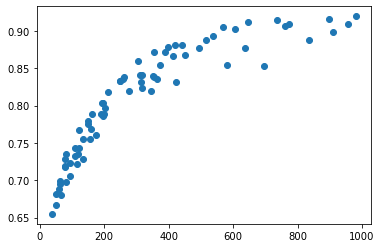

In [72]:
plt.scatter(df["seq_lens"], df.val_auroc)

<AxesSubplot:xlabel='seq_lens', ylabel='val_auroc'>

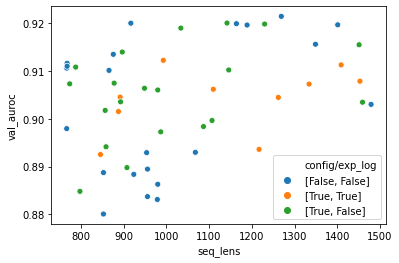

In [109]:
import seaborn as sns
sns.scatterplot(df["seq_lens"], df.val_auroc, hue = df["config/exp_log"].astype(str))

<AxesSubplot:xlabel='seq_lens', ylabel='val_auroc'>

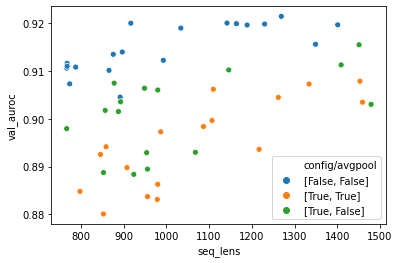

In [110]:
sns.scatterplot(df["seq_lens"], df.val_auroc, hue = df["config/avgpool"].astype(str))

In [82]:
reload(biophysnn)
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler
from ray.tune import Analysis
config = {
    'batch_size': 100,
 'dropout': tune.choice([0.,0.1,0.25]), 
 'depth': tune.randint(3,5),
 'first_filter_width': tune.choice([7,9,11]),
 'filter_width' : tune.choice([3,5,7]), 
 'first_pool_stride' : tune.randint(4,9), 
 'pool_stride' : tune.randint(2,5), 
 'pool_overlap' : tune.randint(3,6),
 'lr': 1e-3,
 'n_channel': 32,
 'n_hidden' : tune.choice([16,32,64]),
 'weight_decay': 0.,
 'avgpool' : tune.choice([[True,False], [False,False], [True,True]]) ,
 'exp_log' : tune.choice([[True,False], [False,False], [True,True]]) , 
 'num_chunks' : tune.choice([7,9,11]),
    'min_seq_len' : 750, 
 'max_seq_len' : 1500, 
}

if False: 
    result = tune.run(
        biophysnn.Trainable,
        config = config,
        reuse_actors = True, 
        name = "logConvExpHNRNPK2", 
        num_samples=200,
        checkpoint_freq=1,
        scheduler = ASHAScheduler(
            max_t=30, 
            grace_period=3),
        resources_per_trial={'gpu': 1} if torch.cuda.is_available() else {"cpu": 28, "gpu": 0},
        metric="val_auroc", # metric to optimize
        mode="max"
    )

In [81]:
1

1

In [84]:

analysis = Analysis("/gpfs/commons/home/daknowles/ray_results/logConvExpHNRNPK2/")

analysis.get_best_config("val_auroc","max")

df = analysis.dataframe()


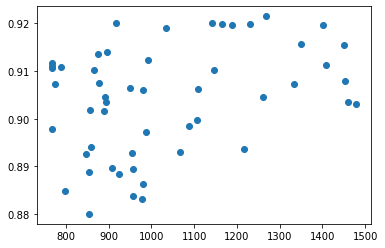

In [90]:
plt.scatter(df["seq_lens"], df.val_auroc)

In [112]:
config = analysis.get_best_config("val_auroc","max")
config

{'avgpool': [False, False],
 'batch_size': 100,
 'depth': 3,
 'dropout': 0.1,
 'exp_log': [False, False],
 'filter_width': 7,
 'first_filter_width': 11,
 'first_pool_stride': 6,
 'lr': 0.001,
 'max_seq_len': 1500,
 'min_seq_len': 750,
 'n_channel': 32,
 'n_hidden': 64,
 'num_chunks': 11,
 'pool_overlap': 5,
 'pool_stride': 4,
 'weight_decay': 0.0}

In [114]:
if False: 
    result = tune.run(
        biophysnn.Trainable,
        config = config,
        reuse_actors = True, 
        name = "logConvExpHNRNPK_ensemble", 
        num_samples=20,
        checkpoint_freq=1,
        scheduler = ASHAScheduler(
            max_t=100, 
            grace_period=3),
        resources_per_trial={'gpu': 1} if torch.cuda.is_available() else {"cpu": 28, "gpu": 0},
        metric="val_auroc", # metric to optimize
        mode="max"
    )

In [121]:

analysis = Analysis("/gpfs/commons/home/daknowles/ray_results/logConvExpHNRNPK_ensemble/")

analysis.get_best_config("val_auroc","max")

df = analysis.dataframe()
df.sort_values("val_auroc", ascending = False)

,val_loss,val_acc,val_auroc,done,timesteps_total,episodes_total,training_iteration,experiment_id,date,timestamp,...,config/lr,config/max_seq_len,config/min_seq_len,config/n_channel,config/n_hidden,config/num_chunks,config/pool_overlap,config/pool_stride,config/weight_decay,logdir
10,0.351096,0.845352,0.924066,True,NaN,NaN,12,3d147a7a564e4dac94f06fe502a24aba,2022-08-29_02-03-09,1661752989,...,0.001,1500,750,32,64,11,5,4,0.0,/gpfs/commons/home/daknowles/ray_results/logCo...
8,0.348894,0.849462,0.921047,True,NaN,NaN,3,8eddc4a5219d4882b1aacf975679d037,2022-08-29_06-18-12,1661768292,...,0.001,1500,750,32,64,11,5,4,0.0,/gpfs/commons/home/daknowles/ray_results/logCo...
0,0.349261,0.848588,0.920777,True,NaN,NaN,3,aace5c8e485c4e08b0c83144ecd6d9df,2022-08-29_04-05-08,1661760308,...,0.001,1500,750,32,64,11,5,4,0.0,/gpfs/commons/home/daknowles/ray_results/logCo...
5,0.356302,0.841729,0.920609,True,NaN,NaN,3,053cca8463db4041a503fb7d6c84c714,2022-08-29_06-00-34,1661767234,...,0.001,1500,750,32,64,11,5,4,0.0,/gpfs/commons/home/daknowles/ray_results/logCo...
12,0.351606,0.846302,0.920429,True,NaN,NaN,3,32b457309f234774a12ee96803d417fe,2022-08-29_06-14-35,1661768075,...,0.001,1500,750,32,64,11,5,4,0.0,/gpfs/commons/home/daknowles/ray_results/logCo...
3,0.355909,0.843682,0.920399,True,NaN,NaN,3,b798e6720ca54f73b1526fa11bef371d,2022-08-29_02-06-36,1661753196,...,0.001,1500,750,32,64,11,5,4,0.0,/gpfs/commons/home/daknowles/ray_results/logCo...
19,0.349901,0.848126,0.920236,True,NaN,NaN,3,2367fe6ccd0749748eeaee9662bc1970,2022-08-29_06-07-35,1661767655,...,0.001,1500,750,32,64,11,5,4,0.0,/gpfs/commons/home/daknowles/ray_results/logCo...
7,0.350995,0.846379,0.919996,True,NaN,NaN,3,6ab5e12225314b8ab1a3cf3f69b66684,2022-08-29_06-32-28,1661769148,...,0.001,1500,750,32,64,11,5,4,0.0,/gpfs/commons/home/daknowles/ray_results/logCo...
14,0.351613,0.847432,0.919574,True,NaN,NaN,3,31e32597e916405d800c8c4d8f5a16e4,2022-08-29_06-21-41,1661768501,...,0.001,1500,750,32,64,11,5,4,0.0,/gpfs/commons/home/daknowles/ray_results/logCo...
15,0.358620,0.841216,0.919268,True,NaN,NaN,3,87f009f0848d43f7afafe0537f6f69b4,2022-08-29_06-28-51,1661768931,...,0.001,1500,750,32,64,11,5,4,0.0,/gpfs/commons/home/daknowles/ray_results/logCo...


In [ ]:
logdir = Path(df.logdir.iloc[i])
progress = pd.read_csv(logdir / "progress.csv")
checkpoint = logdir / ("checkpoint_%i" % (progress.val_auroc.argmax() + 1)) 
config = json.load(open(logdir / "params.json"))
trainer.reset_config(config)


In [128]:
analysis.default_metric = "val_auroc"
analysis.default_mode = "max"
logdir = Path(analysis.get_best_logdir())

progress = pd.read_csv(logdir / "progress.csv")
checkpoint = logdir / ("checkpoint_%i" % (progress.val_auroc.argmax() + 1)) 
config = json.load(open(logdir / "params.json"))

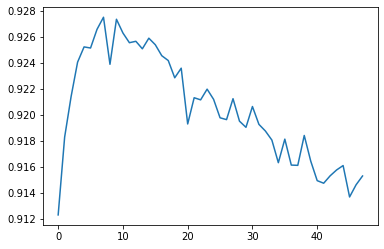

In [131]:
plt.plot(progress.val_auroc)

In [137]:
df["max_val_auroc"] = [ pd.read_csv(Path(df.logdir.iloc[i]) / "progress.csv").val_auroc.max() for i in range(len(df)) ]
    

In [147]:
df["max_val_auroc"].argmax()

16

In [152]:
df.logdir.iloc[df["max_val_auroc"].argmax()]

'/gpfs/commons/home/daknowles/ray_results/logConvExpHNRNPK_ensemble/Trainable_6f654_00007_7_2022-08-29_04-05-08'

In [155]:
Path(analysis.get_best_logdir())

PosixPath('/gpfs/commons/home/daknowles/ray_results/logConvExpHNRNPK_ensemble/Trainable_6f654_00007_7_2022-08-29_04-05-08')

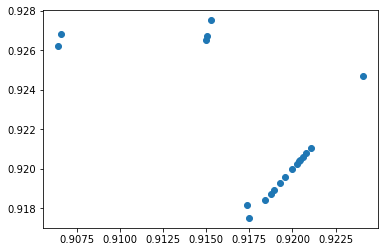

In [158]:
plt.scatter(df.val_auroc, df.max_val_auroc)

In [160]:
checkpoint

PosixPath('/gpfs/commons/home/daknowles/ray_results/logConvExpHNRNPK_ensemble/Trainable_6f654_00007_7_2022-08-29_04-05-08/checkpoint_8')